In [11]:
from deepface import DeepFace
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import glob
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, PReLU, Dropout
from tensorflow.keras.layers import Activation, Concatenate, Lambda, add, ZeroPadding2D, Input, Add, Reshape
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model

from tensorflow.python.keras import backend
from tensorflow.python.keras.engine import training
from tensorflow.python.keras.utils import data_utils, layer_utils
from tensorflow.python.lib.io import file_io
from tensorflow import keras
from tensorflow.keras import backend as K

from pathlib import Path
import gdown

from deepface.commons import functions

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)

In [13]:
data_dir = os.path.join("Dataset", "Image_Data") 

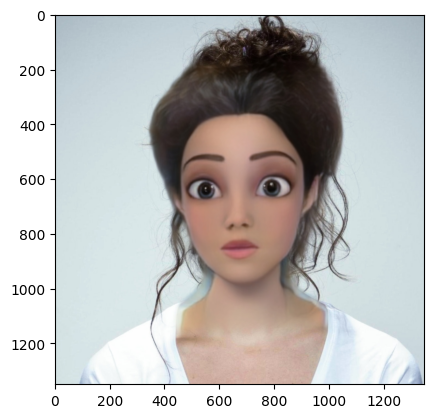

In [14]:
person_no = 1
filter_no = 9
person_dir = os.path.join(data_dir, str(person_no)) 
filename = os.path.join(person_dir, "{}_Filtered_{}.jpg".format(person_no, filter_no))
img = cv2.imread(filename)
plt.imshow(img[:, :, ::-1])

In [15]:
img.shape

(1350, 1350, 3)

In [18]:
model = tf.keras.models.load_model('weights/action.h5', compile=False)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 inception-resnet-v1 (Functi  (None, 1, 1, 2048)       1281536   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 25,078,246
Trainable params: 1,489,510
Non-trainable params: 23,588,736
_________________________________________________________________


In [20]:
dense_output_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[-2].output)
dense_output_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50_input (InputLayer)  [(None, 256, 256, 3)]    0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 inception-resnet-v1 (Functi  (None, 1, 1, 2048)       1281536   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
Total params: 24,869,248
Trainable params: 1,280,512
Non-trainable params: 23,588,736
_________________________________________________________________


In [21]:
age_model = Sequential()
age_model.add(dense_output_model)
age_model.add(Flatten())
age_model.add(Dense(64, activation ="relu"))
age_model.add(Dropout(0.2))
age_model.add(Dense(1, activation='relu'))

In [22]:
age_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              24869248  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25,000,449
Trainable params: 1,411,713
Non-trainable params: 23,588,736
_________________________________________________________________


In [23]:
_, img_height,img_width, _ = age_model.layers[0].input_shape

In [24]:
img_height,img_width

(256, 256)

In [26]:
import pandas as pd
df = pd.read_csv('Dataset/Attribute_Data/london_faces_info.csv')
df.head()

,face_id,face_age,face_gender,face_eth
0,1,24.0,female,white
1,2,24.0,female,white
2,3,38.0,female,white
3,4,30.0,male,white
4,5,28.0,male,east_asian


In [15]:
X = []
Y = []
for person_no in range(1, 103):
    age = df.iloc[person_no-1]['face_age']
    if not np.isnan(age):
        person_dir = os.path.join(data_dir, str(person_no))
        filename = os.path.join(person_dir, "{}_Original.jpg".format(person_no))
        print('Reading the base image of person {}'.format(person_no))
        img = cv2.imread(filename)
        image_resized= cv2.resize(img, (img_height,img_width))
        X.append(image_resized)
        Y.append(age)

        age = df.iloc[person_no-1]['face_age']

        for filter_no in range(1, 11):
            filename = os.path.join(person_dir, "{}_Filtered_{}.jpg".format(person_no, filter_no))
            print('Reading the filter {} image of person {}'.format(filter_no, person_no))
            img = cv2.imread(filename)
            image_resized= cv2.resize(img, (img_height,img_width))
            X.append(image_resized)
            Y.append(age)

Reading the base image of person 1
Reading the filter 1 image of person 1
Reading the filter 2 image of person 1
Reading the filter 3 image of person 1
Reading the filter 4 image of person 1
Reading the filter 5 image of person 1
Reading the filter 6 image of person 1
Reading the filter 7 image of person 1
Reading the filter 8 image of person 1
Reading the filter 9 image of person 1
Reading the filter 10 image of person 1
Reading the base image of person 2
Reading the filter 1 image of person 2
Reading the filter 2 image of person 2
Reading the filter 3 image of person 2
Reading the filter 4 image of person 2
Reading the filter 5 image of person 2
Reading the filter 6 image of person 2
Reading the filter 7 image of person 2
Reading the filter 8 image of person 2
Reading the filter 9 image of person 2
Reading the filter 10 image of person 2
Reading the base image of person 3
Reading the filter 1 image of person 3
Reading the filter 2 image of person 3
Reading the filter 3 image of perso

Reading the filter 7 image of person 39
Reading the filter 8 image of person 39
Reading the filter 9 image of person 39
Reading the filter 10 image of person 39
Reading the base image of person 40
Reading the filter 1 image of person 40
Reading the filter 2 image of person 40
Reading the filter 3 image of person 40
Reading the filter 4 image of person 40
Reading the filter 5 image of person 40
Reading the filter 6 image of person 40
Reading the filter 7 image of person 40
Reading the filter 8 image of person 40
Reading the filter 9 image of person 40
Reading the filter 10 image of person 40
Reading the base image of person 41
Reading the filter 1 image of person 41
Reading the filter 2 image of person 41
Reading the filter 3 image of person 41
Reading the filter 4 image of person 41
Reading the filter 5 image of person 41
Reading the filter 6 image of person 41
Reading the filter 7 image of person 41
Reading the filter 8 image of person 41
Reading the filter 9 image of person 41
Readin

Reading the filter 1 image of person 77
Reading the filter 2 image of person 77
Reading the filter 3 image of person 77
Reading the filter 4 image of person 77
Reading the filter 5 image of person 77
Reading the filter 6 image of person 77
Reading the filter 7 image of person 77
Reading the filter 8 image of person 77
Reading the filter 9 image of person 77
Reading the filter 10 image of person 77
Reading the base image of person 78
Reading the filter 1 image of person 78
Reading the filter 2 image of person 78
Reading the filter 3 image of person 78
Reading the filter 4 image of person 78
Reading the filter 5 image of person 78
Reading the filter 6 image of person 78
Reading the filter 7 image of person 78
Reading the filter 8 image of person 78
Reading the filter 9 image of person 78
Reading the filter 10 image of person 78
Reading the base image of person 79
Reading the filter 1 image of person 79
Reading the filter 2 image of person 79
Reading the filter 3 image of person 79
Readin

In [16]:
X = np.array(X)

In [17]:
X.shape

(1100, 256, 256, 3)

In [18]:
Y = np.array(Y).reshape(-1,1)

In [19]:
Y.shape

(1100, 1)

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [22]:
age_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [23]:
epochs = 15
history = age_model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=16)

Epoch 1/15
44/44 [==============================] - 132s 3s/step - loss: 123.9384 - accuracy: 0.0000e+00 - val_loss: 52.0175 - val_accuracy: 0.0000e+00
Epoch 2/15
44/44 [==============================] - 117s 3s/step - loss: 33.9916 - accuracy: 0.0000e+00 - val_loss: 46.7120 - val_accuracy: 0.0000e+00
Epoch 3/15
44/44 [==============================] - 121s 3s/step - loss: 32.0212 - accuracy: 0.0000e+00 - val_loss: 40.3008 - val_accuracy: 0.0000e+00
Epoch 4/15
44/44 [==============================] - 129s 3s/step - loss: 29.1721 - accuracy: 0.0000e+00 - val_loss: 24.3577 - val_accuracy: 0.0000e+00
Epoch 5/15
44/44 [==============================] - 130s 3s/step - loss: 21.4831 - accuracy: 0.0000e+00 - val_loss: 19.8861 - val_accuracy: 0.0000e+00
Epoch 6/15
44/44 [==============================] - 125s 3s/step - loss: 24.9341 - accuracy: 0.0000e+00 - val_loss: 46.0909 - val_accuracy: 0.0000e+00
Epoch 7/15
44/44 [==============================] - 117s 3s/step - loss: 23.3508 - accuracy: 

In [30]:
y_pred = age_model.predict(X_test)

In [31]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2_val = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [7]:
r2_val, mae, mse

(0.9044030591021087, 1.74, 4.78)

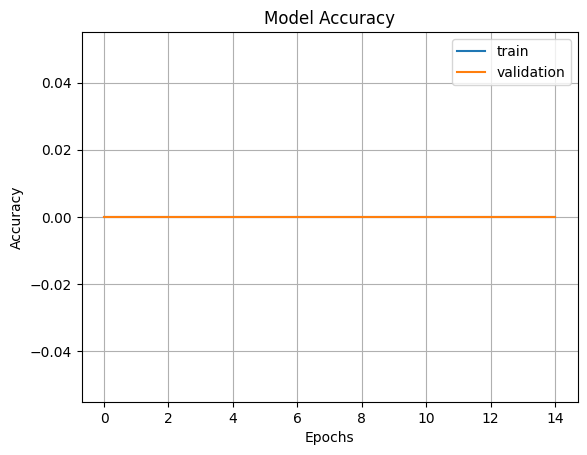

In [27]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
#plt.savefig('model_accuracy_rf.pdf', dpi = 700)

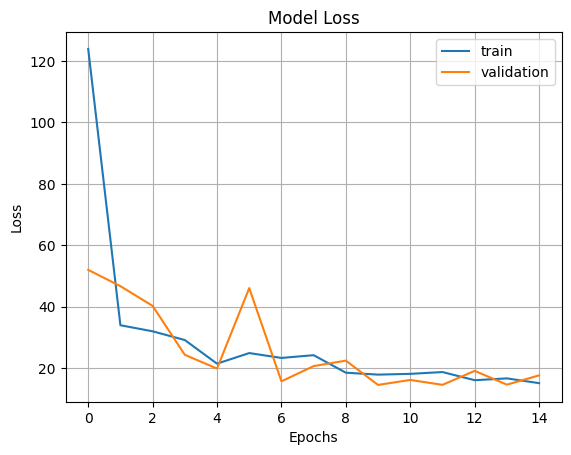

In [33]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
#plt.savefig('model_loss_rf.pdf', dpi = 700)

In [34]:
age_model.save("weights/action_age.h5")

In [35]:
from keras.models import load_model
age_model = load_model("weights/action_age.h5")

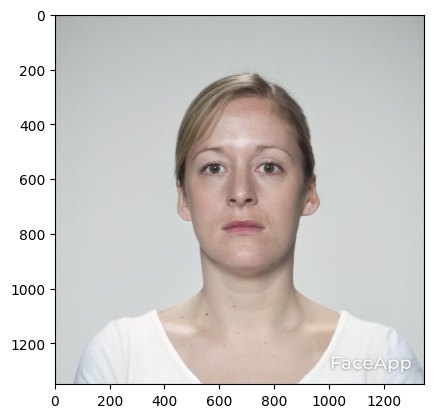

In [36]:
person_no = 10
filter_no = 1
person_dir = os.path.join(data_dir, str(person_no)) 
filename = os.path.join(person_dir, "{}_Filtered_{}.jpg".format(person_no, filter_no))
img = cv2.imread(filename)
plt.imshow(img[:, :, ::-1])

In [37]:
img_height,img_width = 256, 256
image_resized= cv2.resize(img, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)

In [38]:
pred=model.predict(image)
print("The predicted age is", round(pred[0][0]))

The predicted age is 0


In [61]:
predicted_ages = []
for person_no in range(1, 103):
    img_path = "Dataset/Face Dataset/{}/{}.jpg".format(person_no, person_no)
    img = cv2.imread(img_path)
    image_resized= cv2.resize(img, (img_height,img_width))
    image=np.expand_dims(image_resized,axis=0)
    print('Predicting age for person no - {}...'.format(person_no))
    age_pred = round(age_model.predict(image)[0][0])
    predicted_ages.append(age_pred)

Predicting age for person no - 1...
Predicting age for person no - 2...
Predicting age for person no - 3...
Predicting age for person no - 4...
Predicting age for person no - 5...
Predicting age for person no - 6...
Predicting age for person no - 7...
Predicting age for person no - 8...
Predicting age for person no - 9...
Predicting age for person no - 10...
Predicting age for person no - 11...
Predicting age for person no - 12...
Predicting age for person no - 13...
Predicting age for person no - 14...
Predicting age for person no - 15...
Predicting age for person no - 16...
Predicting age for person no - 17...
Predicting age for person no - 18...
Predicting age for person no - 19...
Predicting age for person no - 20...
Predicting age for person no - 21...
Predicting age for person no - 22...
Predicting age for person no - 23...
Predicting age for person no - 24...
Predicting age for person no - 25...
Predicting age for person no - 26...
Predicting age for person no - 27...
Predicting

In [63]:
df_age = df[['face_id', 'face_age']]

In [64]:
df_age['predicted_age'] = predicted_ages

In [65]:
df_age

,face_id,face_age,predicted_age
0,1,24.0,28
1,2,24.0,24
2,3,38.0,42
3,4,30.0,30
4,5,28.0,28
...,...,...,...
97,142,26.0,27
98,143,29.0,30
99,144,27.0,31
100,172,40.0,34


In [66]:
age_dict = {}
for person_no in range(1,103):
    age_dict[person_no] = {'actual_age': df_age.iloc[person_no-1]['face_age'],
                           'predicted_age': df_age.iloc[person_no-1]['predicted_age']}

In [67]:
df_dict = {'face_id':[num for num in range(1,103)], 'actual_age':[], 'predicted_age':[]}

In [68]:
df_dict['actual_age'] = df_age['face_age'].to_list()

In [69]:
df_dict['predicted_age'] = df_age['predicted_age'].to_list()

In [70]:
import pickle
with open("Results/Numerical Analysis/custom_age_dict.pkl", "wb") as f:
    pickle.dump(df_dict, f)

In [49]:
import os
import pickle
if os.path.exists("Results/Numerical Analysis/custom_age_dict.pkl"):
    with open("Results/Numerical Analysis/custom_age_dict.pkl", "rb") as f:
        df_dict = pickle.load(f)

In [50]:
import pandas as pd
df_age = pd.DataFrame.from_dict(df_dict).dropna()

In [51]:
df_age

,face_id,actual_age,predicted_age
0,1,24.0,22
1,2,24.0,21
2,3,38.0,36
3,4,30.0,29
4,5,28.0,26
...,...,...,...
97,98,26.0,24
98,99,29.0,26
99,100,27.0,24
100,101,40.0,40


In [52]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2_val = r2_score(df_age["actual_age"], df_age["predicted_age"])
mae = mean_absolute_error(df_age["actual_age"], df_age["predicted_age"])
mse = mean_squared_error(df_age["actual_age"], df_age["predicted_age"])

In [53]:
r2_val, mae, mse

(0.9044030591021087, 1.74, 4.78)

In [33]:
from keras.models import load_model
age_model = load_model('weights/action_age.h5')

In [34]:
age_baseline, age_filters, filter_no_list, deviation_reduce, deviation_increase = [], [], [], {}, {}

for person_no in range(1, 103):
    person_dir = os.path.join(data_dir, str(person_no))
    img_path = os.path.join(person_dir, "{}_Original.jpg".format(person_no))
    img = cv2.imread(img_path)
    image_resized = cv2.resize(img, (img_height, img_width))
    image = np.expand_dims(image_resized, axis=0)
    print('Calculating age for baseline image of person ', person_no, '...')
    pred = age_model.predict(image)
    baseline_age_pred = round(pred[0][0])
    
    for filter_no in range(1, 11):
        img_path = os.path.join(person_dir, "{}_Filtered_{}.jpg".format(person_no, filter_no))
        img = cv2.imread(img_path)
        image_resized = cv2.resize(img, (img_height, img_width))
        image = np.expand_dims(image_resized, axis=0)
        print('Calculating age for filter ',filter_no,' for person ', person_no, '...')
        pred = age_model.predict(image)
        filtered_age_pred = round(pred[0][0])
        actual_age = df.iloc[person_no-1]['face_age']
        
        print('actual age: {}, predicted age: {}'.format(actual_age, filtered_age_pred))

        
        if not np.isnan(actual_age) and filtered_age_pred != actual_age:
            filter_dict = {}
            if(filtered_age_pred < actual_age):
                filter_dict = deviation_reduce.get("Filter_{}".format(filter_no), {})
            else:
                filter_dict = deviation_increase.get("Filter_{}".format(filter_no), {})

            filter_dict['delta'] = filter_dict.get('delta', 0) + filtered_age_pred - actual_age
            filter_dict['count'] = filter_dict.get('count', 0) + 1

            if(filtered_age_pred < actual_age):
                deviation_reduce["Filter_{}".format(filter_no)] = filter_dict
            else:
                deviation_increase["Filter_{}".format(filter_no)] = filter_dict
        
        age_baseline.append(baseline_age_pred)
        age_filters.append(filtered_age_pred)
        filter_no_list.append(filter_no)

Calculating age for baseline image of person  1 ...
Calculating age for filter  1  for person  1 ...
actual age: 24.0, predicted age: 23
Calculating age for filter  2  for person  1 ...
actual age: 24.0, predicted age: 22
Calculating age for filter  3  for person  1 ...
actual age: 24.0, predicted age: 22
Calculating age for filter  4  for person  1 ...
actual age: 24.0, predicted age: 23
Calculating age for filter  5  for person  1 ...
actual age: 24.0, predicted age: 24
Calculating age for filter  6  for person  1 ...
actual age: 24.0, predicted age: 20
Calculating age for filter  7  for person  1 ...
actual age: 24.0, predicted age: 22
Calculating age for filter  8  for person  1 ...
actual age: 24.0, predicted age: 22
Calculating age for filter  9  for person  1 ...
actual age: 24.0, predicted age: 21
Calculating age for filter  10  for person  1 ...
actual age: 24.0, predicted age: 21
Calculating age for baseline image of person  2 ...
Calculating age for filter  1  for person  2 

Calculating age for baseline image of person  19 ...
Calculating age for filter  1  for person  19 ...
actual age: 35.0, predicted age: 33
Calculating age for filter  2  for person  19 ...
actual age: 35.0, predicted age: 33
Calculating age for filter  3  for person  19 ...
actual age: 35.0, predicted age: 33
Calculating age for filter  4  for person  19 ...
actual age: 35.0, predicted age: 27
Calculating age for filter  5  for person  19 ...
actual age: 35.0, predicted age: 32
Calculating age for filter  6  for person  19 ...
actual age: 35.0, predicted age: 30
Calculating age for filter  7  for person  19 ...
actual age: 35.0, predicted age: 33
Calculating age for filter  8  for person  19 ...
actual age: 35.0, predicted age: 21
Calculating age for filter  9  for person  19 ...
actual age: 35.0, predicted age: 30
Calculating age for filter  10  for person  19 ...
actual age: 35.0, predicted age: 32
Calculating age for baseline image of person  20 ...
Calculating age for filter  1  fo

Calculating age for filter  10  for person  36 ...
actual age: 29.0, predicted age: 26
Calculating age for baseline image of person  37 ...
Calculating age for filter  1  for person  37 ...
actual age: 27.0, predicted age: 24
Calculating age for filter  2  for person  37 ...
actual age: 27.0, predicted age: 25
Calculating age for filter  3  for person  37 ...
actual age: 27.0, predicted age: 25
Calculating age for filter  4  for person  37 ...
actual age: 27.0, predicted age: 26
Calculating age for filter  5  for person  37 ...
actual age: 27.0, predicted age: 24
Calculating age for filter  6  for person  37 ...
actual age: 27.0, predicted age: 25
Calculating age for filter  7  for person  37 ...
actual age: 27.0, predicted age: 24
Calculating age for filter  8  for person  37 ...
actual age: 27.0, predicted age: 26
Calculating age for filter  9  for person  37 ...
actual age: 27.0, predicted age: 27
Calculating age for filter  10  for person  37 ...
actual age: 27.0, predicted age: 25

Calculating age for filter  9  for person  54 ...
actual age: 31.0, predicted age: 29
Calculating age for filter  10  for person  54 ...
actual age: 31.0, predicted age: 30
Calculating age for baseline image of person  55 ...
Calculating age for filter  1  for person  55 ...
actual age: 29.0, predicted age: 28
Calculating age for filter  2  for person  55 ...
actual age: 29.0, predicted age: 27
Calculating age for filter  3  for person  55 ...
actual age: 29.0, predicted age: 26
Calculating age for filter  4  for person  55 ...
actual age: 29.0, predicted age: 26
Calculating age for filter  5  for person  55 ...
actual age: 29.0, predicted age: 28
Calculating age for filter  6  for person  55 ...
actual age: 29.0, predicted age: 23
Calculating age for filter  7  for person  55 ...
actual age: 29.0, predicted age: 27
Calculating age for filter  8  for person  55 ...
actual age: 29.0, predicted age: 20
Calculating age for filter  9  for person  55 ...
actual age: 29.0, predicted age: 28


Calculating age for filter  8  for person  72 ...
actual age: 24.0, predicted age: 28
Calculating age for filter  9  for person  72 ...
actual age: 24.0, predicted age: 22
Calculating age for filter  10  for person  72 ...
actual age: 24.0, predicted age: 22
Calculating age for baseline image of person  73 ...
Calculating age for filter  1  for person  73 ...
actual age: 25.0, predicted age: 23
Calculating age for filter  2  for person  73 ...
actual age: 25.0, predicted age: 23
Calculating age for filter  3  for person  73 ...
actual age: 25.0, predicted age: 22
Calculating age for filter  4  for person  73 ...
actual age: 25.0, predicted age: 23
Calculating age for filter  5  for person  73 ...
actual age: 25.0, predicted age: 23
Calculating age for filter  6  for person  73 ...
actual age: 25.0, predicted age: 25
Calculating age for filter  7  for person  73 ...
actual age: 25.0, predicted age: 25
Calculating age for filter  8  for person  73 ...
actual age: 25.0, predicted age: 21


Calculating age for filter  7  for person  90 ...
actual age: 21.0, predicted age: 20
Calculating age for filter  8  for person  90 ...
actual age: 21.0, predicted age: 18
Calculating age for filter  9  for person  90 ...
actual age: 21.0, predicted age: 19
Calculating age for filter  10  for person  90 ...
actual age: 21.0, predicted age: 18
Calculating age for baseline image of person  91 ...
Calculating age for filter  1  for person  91 ...
actual age: nan, predicted age: 22
Calculating age for filter  2  for person  91 ...
actual age: nan, predicted age: 20
Calculating age for filter  3  for person  91 ...
actual age: nan, predicted age: 22
Calculating age for filter  4  for person  91 ...
actual age: nan, predicted age: 20
Calculating age for filter  5  for person  91 ...
actual age: nan, predicted age: 20
Calculating age for filter  6  for person  91 ...
actual age: nan, predicted age: 18
Calculating age for filter  7  for person  91 ...
actual age: nan, predicted age: 20
Calcula

In [35]:
for filter_key in deviation_reduce.keys():
    deviation_reduce[filter_key]['avg'] = deviation_reduce[filter_key]['delta']/deviation_reduce[filter_key]['count']

for filter_key in deviation_increase.keys():
    deviation_increase[filter_key]['avg'] = deviation_increase[filter_key]['delta']/deviation_increase[filter_key]['count']

In [36]:
deviation_reduce

{'Filter_1': {'delta': -132.0, 'count': 64, 'avg': -2.0625},
 'Filter_2': {'delta': -263.0, 'count': 78, 'avg': -3.371794871794872},
 'Filter_3': {'delta': -241.0, 'count': 69, 'avg': -3.4927536231884058},
 'Filter_4': {'delta': -167.0, 'count': 66, 'avg': -2.5303030303030303},
 'Filter_6': {'delta': -288.0, 'count': 90, 'avg': -3.2},
 'Filter_7': {'delta': -135.0, 'count': 63, 'avg': -2.142857142857143},
 'Filter_8': {'delta': -537.0, 'count': 93, 'avg': -5.774193548387097},
 'Filter_9': {'delta': -231.0, 'count': 72, 'avg': -3.2083333333333335},
 'Filter_10': {'delta': -220.0, 'count': 81, 'avg': -2.7160493827160495},
 'Filter_5': {'delta': -173.0, 'count': 73, 'avg': -2.3698630136986303}}

In [37]:
deviation_increase

{'Filter_9': {'delta': 41.0, 'count': 13, 'avg': 3.1538461538461537},
 'Filter_7': {'delta': 26.0, 'count': 15, 'avg': 1.7333333333333334},
 'Filter_10': {'delta': 6.0, 'count': 5, 'avg': 1.2},
 'Filter_1': {'delta': 34.0, 'count': 23, 'avg': 1.4782608695652173},
 'Filter_3': {'delta': 36.0, 'count': 18, 'avg': 2.0},
 'Filter_4': {'delta': 29.0, 'count': 16, 'avg': 1.8125},
 'Filter_2': {'delta': 17.0, 'count': 9, 'avg': 1.8888888888888888},
 'Filter_5': {'delta': 18.0, 'count': 11, 'avg': 1.6363636363636365},
 'Filter_6': {'delta': 9.0, 'count': 5, 'avg': 1.8},
 'Filter_8': {'delta': 13.0, 'count': 6, 'avg': 2.1666666666666665}}

In [41]:
avg_deviations = {}
for filter_no in range(1, 11):
    avg_deviations["Filter_{}".format(filter_no)] = 0
    count = 0
    if "Filter_{}".format(filter_no) in deviation_reduce.keys():
        avg_deviations["Filter_{}".format(filter_no)] += deviation_reduce["Filter_{}".format(filter_no)]['avg']
        count += 1
    if "Filter_{}".format(filter_no) in deviation_increase.keys():
        avg_deviations["Filter_{}".format(filter_no)] += deviation_increase["Filter_{}".format(filter_no)]['avg']
        count += 1
    if count != 0:
        avg_deviations["Filter_{}".format(filter_no)] /= count

In [42]:
avg_deviations

{'Filter_1': -0.29211956521739135,
 'Filter_2': -0.7414529914529915,
 'Filter_3': -0.7463768115942029,
 'Filter_4': -0.35890151515151514,
 'Filter_5': -0.3667496886674969,
 'Filter_6': -0.7000000000000001,
 'Filter_7': -0.2047619047619047,
 'Filter_8': -1.8037634408602152,
 'Filter_9': -0.02724358974358987,
 'Filter_10': -0.7580246913580247}

In [43]:
import pickle
with open("Results/Numerical Analysis/mispredictions_age_reduce.pkl", "wb") as f:
    pickle.dump(deviation_reduce, f)

In [44]:
with open("Results/Numerical Analysis/mispredictions_age_increase.pkl", "wb") as f:
    pickle.dump(deviation_increase, f)

In [45]:
with open("Results/Numerical Analysis/avg_deviations.pkl", "wb") as f:
    pickle.dump(avg_deviations, f)

In [54]:
if os.path.exists("Results/Numerical Analysis/mispredictions_age_reduce.pkl"):
    with open("Results/Numerical Analysis/mispredictions_age_reduce.pkl", "rb") as f:
        deviation_reduce = pickle.load(f)

In [55]:
if os.path.exists("Results/Numerical Analysis/mispredictions_age_increase.pkl"):
    with open("Results/Numerical Analysis/mispredictions_age_increase.pkl", "rb") as f:
        deviation_increase = pickle.load(f)

In [56]:
if os.path.exists("Results/Numerical Analysis/avg_deviations.pkl"):
    with open("Results/Numerical Analysis/avg_deviations.pkl", "rb") as f:
        avg_deviations = pickle.load(f)